# **Skenario 6 - CNN ResNet50 - SVM**

Skenario 6 menggunakan model Convolutional Neural Network (CNN) dengan arsitektur ResNet50 sebagai ekstraksi fitur dan SVM sebagai algoritma untuk melakukan klasifikasi pada data citra otak.

---

## 1. Import packages

Impor semua pustaka dan modul yang dibutuhkan untuk pemrosesan data, visualisasi, pembuatan model, dan pelatihan model

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import pickle

# Scikit-learn imports
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score, cross_val_predict


# TensorFlow and Keras imports
import tensorflow as tf
from keras import layers, models, optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.applications import ResNet50
from keras.models import Model

## 2. Data Preparation

### 2.1 Load dan Eksplorasi Data
Load dan proses data `image_selected.npz`

In [2]:
def load_and_preprocess_data(preprocess_images=True):
    base_dir = r"D:\Users\RESA\Coding\Alzheimer-Classification-with-CNN-SVM\Notebook\Preprocessing\image_selected.npz"
    
    # Load data from the NPZ file
    loaded_data = np.load(base_dir, allow_pickle=True)
    loaded_combined_slices = loaded_data[list(loaded_data.keys())[0]]

    # Prepare lists for input (X) and output (Y) data
    X = []
    Y = []

    # Create a label mapping for each class
    label_mapping = {'AD': 0, 'CN': 1, 'EMCI': 2, 'LMCI': 3}

    # Iterate through the loaded data
    for label, plane_slices in loaded_combined_slices.item().items():
        for plane, slices in plane_slices.items():
            for selected_slice in slices:
                position, original_slice = selected_slice

                if preprocess_images:
                    # Expand dimensions and repeat for RGB representation
                    original_slice = np.expand_dims(original_slice, axis=-1)
                    original_slice = np.repeat(original_slice, 3, axis=-1)

                    # Min-Max Scaling to bring pixel values to the range [0, 1]
                    min_val = np.min(original_slice)
                    max_val = np.max(original_slice)
                    original_slice = (original_slice - min_val) / (max_val - min_val)

                X.append(original_slice)
                Y.append(label_mapping[label])

    # Convert lists to NumPy arrays
    X = np.array(X) 
    Y = np.array(Y)

    return X, Y

In [3]:
# Panggil fungsi dan simpan ke X, Y
X, Y = load_and_preprocess_data()

In [4]:
print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (7200, 224, 224, 3)
Y shape: (7200,)


In [5]:
class_names = ["AD", "CN", "EMCI", "LMCI"]

### 2.2 Pembagian Data
Data dibagi dengan rasio 80:20 

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

cek shape dan jumlah data

In [7]:
print("Dimensi X_train:", X_train.shape)
print("Dimensi Y_train:", Y_train.shape)
print("Dimensi X_test:", X_test.shape)
print("Dimensi Y_test:", Y_test.shape)

Dimensi X_train: (5760, 224, 224, 3)
Dimensi Y_train: (5760,)
Dimensi X_test: (1440, 224, 224, 3)
Dimensi Y_test: (1440,)


## 3. Buat dan Konfigurasi Model Ekstraksi Fitur
Arsitektur yang digunakan sebagai ekstraksi fitur adalah ResNet50 yang merupakan dari transfer learning yaitu arsitektur yang sudah dilatih dengan data ImageNet

In [8]:
from keras import backend as K

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

Load model yang udah dilatih sebelumnya

In [9]:
from keras.models import load_model

model_path = r"D:\Users\RESA\Coding\Evaluasi\ResNet50.h5"
loaded_model = load_model(model_path, custom_objects={'specificity': specificity, 'sensitivity': sensitivity})

In [10]:
extractCNN = Model(loaded_model.inputs, loaded_model.layers[-2].output)
feat_trainCNN = extractCNN.predict(X_train)
feat_testCNN = extractCNN.predict(X_test)
print("Shape of train features:", feat_trainCNN.shape)
print("Shape of test features:", feat_testCNN.shape)

45/45 [==============================] - 30s 677ms/step
Shape of train features: (5760, 2048)
Shape of test features: (1440, 2048)


Reshape fitur

In [11]:
flat_feat_trainCNN = feat_trainCNN.reshape((feat_trainCNN.shape[0], -1))
flat_feat_testCNN = feat_testCNN.reshape((feat_testCNN.shape[0], -1))

In [12]:
print("Dimensi train sebelum reshaping:", feat_trainCNN.shape)
print("Dimensi train setelah reshaping:", flat_feat_trainCNN.shape)
print("Dimensi test sebelum reshaping:", feat_testCNN.shape)
print("Dimensi test setelah reshaping:", flat_feat_testCNN.shape)

Dimensi train sebelum reshaping: (5760, 2048)
Dimensi train setelah reshaping: (5760, 2048)
Dimensi test sebelum reshaping: (1440, 2048)
Dimensi test setelah reshaping: (1440, 2048)


## 5. Training Model - Cross Validation
Latih model dengan data `X_train dan Y_train` dan menguji kinerja model pada data validasi `X_test dan Y_test`, setelah pelatihan nanti model akan menyimpan riwayatnya ke dalam `h_model`

### 5.1 Kernel RBF

Training

In [13]:
svm_rbf = SVC(kernel='rbf', probability=True, decision_function_shape='ovr')
scores_rbf = cross_val_score(svm_rbf, flat_feat_trainCNN, Y_train, cv=5, scoring='accuracy')
svm_rbf.fit(flat_feat_trainCNN, Y_train) 
print("Skor Akurasi untuk Setiap Fold:")
print(scores_rbf)
print("\nRata-rata Skor Akurasi:")
print(scores_rbf.mean())

Skor Akurasi untuk Setiap Fold:
[0.3046875  0.27951389 0.31597222 0.32204861 0.30381944]

Rata-rata Skor Akurasi:
0.3052083333333333


In [14]:
best_rbf_fold_index = np.argmax(scores_rbf)

# Buat model untuk fold terbaik dan fit model
best_svm_rbf = SVC(kernel='rbf', probability=True, decision_function_shape='ovr')
best_svm_rbf.fit(flat_feat_trainCNN, Y_train)

SVC(probability=True)

In [15]:
if best_svm_rbf.n_support_.any() > 0:
    print("Model telah dilatih.")
else:
    print("Model belum dilatih atau terdapat masalah saat pelatihan.")

Model telah dilatih.


Simpan model

In [16]:
model_svm_rbf = r"D:/Users/RESA/Coding/Evaluasi/resnet50_svm_model_rbf.pkl"
with open(model_svm_rbf, 'wb') as model_file:
    pickle.dump(best_svm_rbf, model_file)

Testing

In [17]:
svm_rbf.fit(flat_feat_trainCNN, Y_train)
predictions_test = svm_rbf.predict(flat_feat_testCNN)
print("Label Sebenarnya:")
print(Y_test)
print("\nLabel Prediksi:")
print(predictions_test)
accuracy_test = np.mean(predictions_test == Y_test)
print("\nAkurasi pada Data Uji:", accuracy_test)

Label Sebenarnya:
[1 1 2 ... 3 1 1]

Label Prediksi:
[2 0 3 ... 0 1 2]

Akurasi pada Data Uji: 0.3138888888888889


Evaluasi

In [18]:
predictions_test = svm_rbf.predict(flat_feat_testCNN)

# Membuat classification report
classification_rep = classification_report(Y_test, predictions_test)
print("Classification Report untuk Data Uji:")
print(classification_rep)

Classification Report untuk Data Uji:
              precision    recall  f1-score   support

           0       0.32      0.16      0.22       380
           1       0.29      0.28      0.29       338
           2       0.31      0.61      0.41       363
           3       0.36      0.21      0.26       359

    accuracy                           0.31      1440
   macro avg       0.32      0.31      0.29      1440
weighted avg       0.32      0.31      0.29      1440



In [19]:
#  Classification report data train
predictions_train = svm_rbf.predict(flat_feat_trainCNN)
classification_rep_train = classification_report(Y_train, predictions_train)
print("Classification Report untuk Data Pelatihan:")
print(classification_rep_train)

Classification Report untuk Data Pelatihan:
              precision    recall  f1-score   support

           0       0.30      0.17      0.22      1420
           1       0.30      0.27      0.28      1462
           2       0.31      0.61      0.41      1437
           3       0.29      0.15      0.20      1441

    accuracy                           0.30      5760
   macro avg       0.30      0.30      0.28      5760
weighted avg       0.30      0.30      0.28      5760



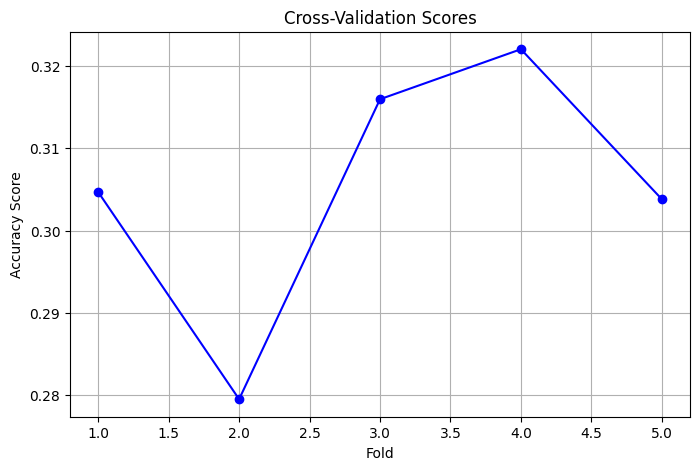

In [20]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), scores_rbf, marker='o', linestyle='-', color='blue')
plt.xlabel('Fold')
plt.ylabel('Accuracy Score')
plt.title('Cross-Validation Scores')
plt.grid(True)
plt.show()

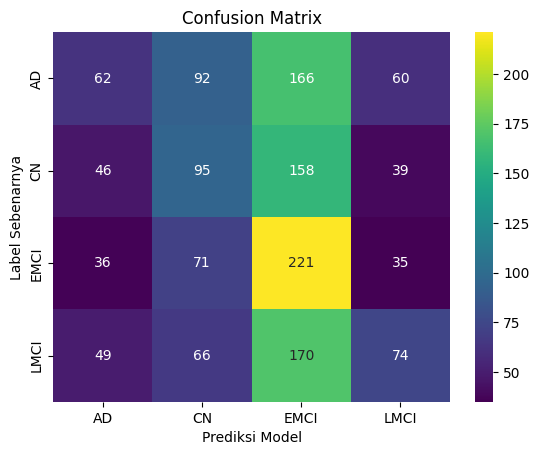

In [21]:
predictions_test = svm_rbf.predict(flat_feat_testCNN)

conf_matrix_rbf = confusion_matrix(Y_test, predictions_test)

# Membuat heatmap untuk confusion matrix
sns.heatmap(conf_matrix_rbf, annot=True, fmt='g', cmap="viridis", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Prediksi Model')
plt.ylabel('Label Sebenarnya')
plt.show()

In [22]:
sensitivity = conf_matrix_rbf[1, 1] / (conf_matrix_rbf[1, 0] + conf_matrix_rbf[1, 1])
specificity = conf_matrix_rbf[0, 0] / (conf_matrix_rbf[0, 0] + conf_matrix_rbf[0, 1])

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

Sensitivity: 0.6737588652482269
Specificity: 0.4025974025974026


In [23]:
# Data train
predictions_train = svm_rbf.predict(flat_feat_trainCNN)
conf_matrix_train = confusion_matrix(Y_train, predictions_train)
sensitivity_train = conf_matrix_train[1, 1] / (conf_matrix_train[1, 0] + conf_matrix_train[1, 1])
specificity_train = conf_matrix_train[0, 0] / (conf_matrix_train[0, 0] + conf_matrix_train[0, 1])

# Menampilkan hasil
print("Sensitivity untuk Data Pelatihan:", sensitivity_train)
print("Specificity untuk Data Pelatihan:", specificity_train)

Sensitivity untuk Data Pelatihan: 0.6666666666666666
Specificity untuk Data Pelatihan: 0.43087971274685816


### 5.2 Kernel Polinomial

Training

In [24]:
svm_poly = SVC(kernel='poly', probability=True, decision_function_shape='ovr')
scores_poly = cross_val_score(svm_poly, flat_feat_trainCNN, Y_train, cv=5, scoring='accuracy')
svm_poly.fit(flat_feat_trainCNN, Y_train) 
print("Skor Akurasi untuk Setiap Fold:")
print(scores_poly)
print("\nRata-rata Skor Akurasi:")
print(scores_poly.mean())

Skor Akurasi untuk Setiap Fold:
[0.31163194 0.29427083 0.3125     0.31770833 0.28993056]

Rata-rata Skor Akurasi:
0.3052083333333333


In [25]:
best_poly_fold_index = np.argmax(scores_poly)

# Buat model untuk fold terbaik dan fit model
best_svm_poly = SVC(kernel='poly', probability=True, decision_function_shape='ovr')
best_svm_poly.fit(flat_feat_trainCNN, Y_train)

SVC(kernel='poly', probability=True)

In [26]:
if best_svm_poly.n_support_.any() > 0:
    print("Model telah dilatih.")
else:
    print("Model belum dilatih atau terdapat masalah saat pelatihan.")

Model telah dilatih.


Simpan model

In [27]:
model_svm_poly = r"D:/Users/RESA/Coding/Evaluasi/resnet50_svm_model_poly.pkl"
with open(model_svm_poly, 'wb') as model_file:
    pickle.dump(best_svm_poly, model_file)

Testing

In [28]:
svm_poly.fit(flat_feat_trainCNN, Y_train)
predictions_test = svm_poly.predict(flat_feat_testCNN)
print("Label Sebenarnya:")
print(Y_test)
print("\nLabel Prediksi:")
print(predictions_test)
accuracy_test = np.mean(predictions_test == Y_test)
print("\nAkurasi pada Data Uji:", accuracy_test)

Label Sebenarnya:
[1 1 2 ... 3 1 1]

Label Prediksi:
[2 3 3 ... 3 1 2]

Akurasi pada Data Uji: 0.32708333333333334


Evaluasi

In [29]:
predictions_test = svm_poly.predict(flat_feat_testCNN)

# Membuat classification report
classification_rep = classification_report(Y_test, predictions_test)
print("Classification Report untuk Data Uji:")
print(classification_rep)

Classification Report untuk Data Uji:
              precision    recall  f1-score   support

           0       0.40      0.19      0.26       380
           1       0.31      0.25      0.28       338
           2       0.31      0.62      0.42       363
           3       0.33      0.25      0.29       359

    accuracy                           0.33      1440
   macro avg       0.34      0.33      0.31      1440
weighted avg       0.34      0.33      0.31      1440



In [30]:
#  Classification report data train

predictions_train = svm_poly.predict(flat_feat_trainCNN)
classification_rep_train = classification_report(Y_train, predictions_train)
print("Classification Report untuk Data Pelatihan:")
print(classification_rep_train)

Classification Report untuk Data Pelatihan:
              precision    recall  f1-score   support

           0       0.39      0.20      0.26      1420
           1       0.30      0.22      0.25      1462
           2       0.31      0.62      0.41      1437
           3       0.30      0.23      0.26      1441

    accuracy                           0.31      5760
   macro avg       0.32      0.31      0.30      5760
weighted avg       0.32      0.31      0.30      5760



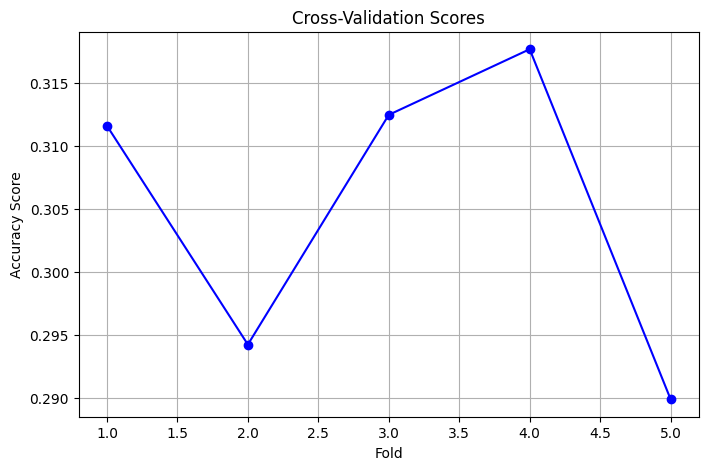

In [31]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), scores_poly, marker='o', linestyle='-', color='blue')
plt.xlabel('Fold')
plt.ylabel('Accuracy Score')
plt.title('Cross-Validation Scores')
plt.grid(True)
plt.show()

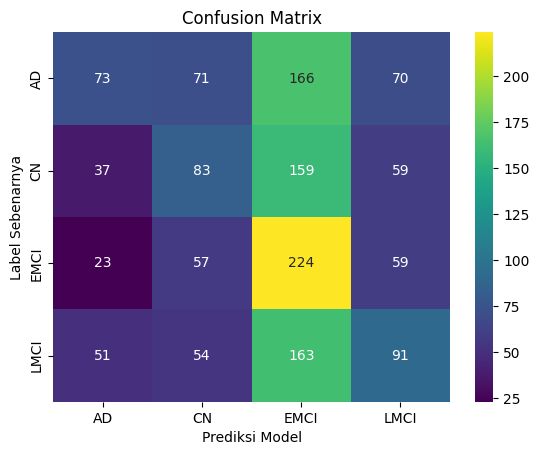

In [32]:
predictions_test = svm_poly.predict(flat_feat_testCNN)

conf_matrix_poly = confusion_matrix(Y_test, predictions_test)

# Membuat heatmap untuk confusion matrix
sns.heatmap(conf_matrix_poly, annot=True, fmt='g', cmap="viridis", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Prediksi Model')
plt.ylabel('Label Sebenarnya')
plt.show()

In [33]:
sensitivity = conf_matrix_poly[1, 1] / (conf_matrix_poly[1, 0] + conf_matrix_poly[1, 1])
specificity = conf_matrix_poly[0, 0] / (conf_matrix_poly[0, 0] + conf_matrix_poly[0, 1])

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

Sensitivity: 0.6916666666666667
Specificity: 0.5069444444444444


In [34]:
# Data train
predictions_train = svm_poly.predict(flat_feat_trainCNN)
conf_matrix_train = confusion_matrix(Y_train, predictions_train)
sensitivity_train = conf_matrix_train[1, 1] / (conf_matrix_train[1, 0] + conf_matrix_train[1, 1])
specificity_train = conf_matrix_train[0, 0] / (conf_matrix_train[0, 0] + conf_matrix_train[0, 1])

# Menampilkan hasil
print("Sensitivity untuk Data Pelatihan:", sensitivity_train)
print("Specificity untuk Data Pelatihan:", specificity_train)

Sensitivity untuk Data Pelatihan: 0.6659751037344398
Specificity untuk Data Pelatihan: 0.5138632162661737
